In [1]:
import sys
import matplotlib.pyplot as plt
from smodels.decomposition.theorySMS import TheorySMS
from smodels.experiment.expSMS import ExpSMS
from smodels.share.models.mssm import BSMList
from smodels.share.models.SMparticles import SMList
from smodels.experiment.defaultFinalStates import finalStates
from smodels.base.model import Model
from collections import OrderedDict
from smodels.base.physicsUnits import fb, GeV

### Create element from old string format

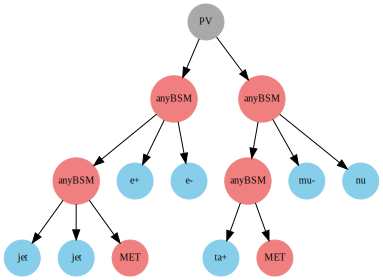

Name= 1110101101000110101101010000 
Process= (PV > anyBSM(1),anyBSM(2)), (anyBSM(1) > anyBSM(3),e+,e-), (anyBSM(2) > anyBSM(4),mu-,nu), (anyBSM(3) > jet,jet,MET), (anyBSM(4) > ta+,MET)
[(PV, 0), (anyBSM, 1), (anyBSM, 2), (anyBSM, 3), (e+, 4), (e-, 5), (anyBSM, 6), (mu-, 7), (nu, 8), (jet, 9), (jet, 10), (MET, 11), (ta+, 12), (MET, 13)]
[(PV, anyBSM), (PV, anyBSM), (anyBSM, anyBSM), (anyBSM, e+), (anyBSM, e-), (anyBSM, anyBSM), (anyBSM, mu-), (anyBSM, nu), (anyBSM, jet), (anyBSM, jet), (anyBSM, MET), (anyBSM, ta+), (anyBSM, MET)]


In [2]:
elementStr = "[[['e+','e-'],['jet','jet']],[['mu-','nu'],['ta+']]]"
el = ExpSMS.from_string(elementStr,model=finalStates)
el.bfs_sort(numberNodes=True)
el.draw()
print('Name=',el.canonName,'\nProcess=',el)
print([(n,nodeIndex) for n,nodeIndex in zip(el.nodes,el.nodeIndices)])
print(el.edges)

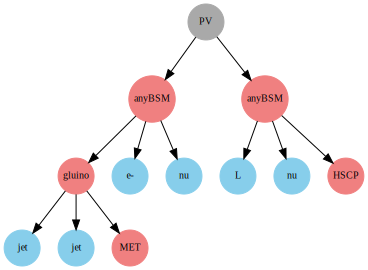

Name= 111010100110101101010000 
Process= (PV > anyBSM(1),anyBSM(2)), (anyBSM(1) > gluino(3),e-,nu), (anyBSM(2) > L,nu,HSCP), (gluino(3) > jet,jet,MET)
[(PV, 0), (anyBSM, 1), (anyBSM, 2), (gluino, 3), (e-, 4), (nu, 5), (L, 6), (nu, 7), (HSCP, 8), (jet, 9), (jet, 10), (MET, 11)]
[(PV, anyBSM), (PV, anyBSM), (anyBSM, gluino), (anyBSM, e-), (anyBSM, nu), (anyBSM, L), (anyBSM, nu), (anyBSM, HSCP), (gluino, jet), (gluino, jet), (gluino, MET)]


In [3]:
stringEl = "[ [['e-','nu'], ['jet','jet'] ], [ ['L','nu'] ] ]"
fs=['MET','HSCP']
intermediateStates=[['anyBSM','gluino'],['anyBSM']]
el = ExpSMS.from_string(stringEl,finalState=fs,
                        intermediateState=intermediateStates, 
                        model=finalStates)
el.bfs_sort(numberNodes=True)
el.draw()
print('Name=',el.canonName,'\nProcess=',el)
print([(n,nodeIndex) for n,nodeIndex in zip(el.nodes,el.nodeIndices)])
print(el.edges)

### Create element from new string format

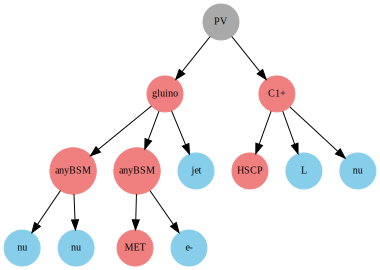

Name= 11101010011011010011010000 
Process= (PV > gluino(1),C1+(2)), (gluino(1) > anyBSM(3),anyBSM(4),jet), (C1+(2) > HSCP,L,nu), (anyBSM(3) > nu,nu), (anyBSM(4) > MET,e-)
[(PV, 0), (gluino, 1), (C1+, 2), (anyBSM, 3), (anyBSM, 4), (jet, 5), (HSCP, 6), (L, 7), (nu, 8), (nu, 9), (nu, 10), (MET, 11), (e-, 12)]
[(PV, gluino), (PV, C1+), (gluino, anyBSM), (gluino, anyBSM), (gluino, jet), (C1+, HSCP), (C1+, L), (C1+, nu), (anyBSM, nu), (anyBSM, nu), (anyBSM, MET), (anyBSM, e-)]


In [31]:
elementStr = '(PV > gluino(1),C1+(2)), (gluino(1) > anyBSM(3),jet,anyBSM(4)), (C1+(2) > HSCP,L,nu), (anyBSM(3) > nu,nu), (anyBSM(4) > MET,e-)'
el = ExpSMS.from_string(elementStr, model=finalStates)
el.draw()
print('Name=',el.canonName,'\nProcess=',el)
print([(n,nIndex) for n,nIndex in zip(el.nodes,el.nodeIndices)])
print(el.edges)

In [75]:
def standardForm(expSMS,nodeIndex=None):

    self = expSMS
    
    if nodeIndex is None:
        cName = self.canonName  # Just to make sure canonName is defined
        if cName is None:
            return
        nodeIndex = self.rootIndex


    daughters = self.daughterIndices(nodeIndex)
    daughterNodes = [self.indexToNode(d) for d in daughters]
    if not daughters:
        return [[nodeIndex,[]]]

    # Sort by canonName and then by string name
    sorted_daughters = sorted(zip(daughters,daughterNodes), 
                                  key = lambda d: (self.nodeCanonName(d[0]),
                                                   not d[1].isSM, str(d[1])))
    sorted_daughters = [d[0] for d in sorted_daughters]
    
    standardFormList = [[nodeIndex,sorted_daughters]]
    for d in sorted_daughters:
        standardFormList += standardForm(self,d)

    if nodeIndex == self.rootIndex:
        return OrderedDict(standardFormList)
        
        

    return standardFormList
        



In [76]:
sFDict = standardForm(el)
print(sFDict)

OrderedDict([(0, [2, 1]), (2, [7, 8, 6]), (7, []), (8, []), (6, []), (1, [5, 3, 4]), (5, []), (3, [9, 10]), (9, []), (10, []), (4, [12, 11]), (12, []), (11, [])])


In [82]:
def getIndex(sFDict):
    generation = [(0, sFDict[0])]
    while generation:
        for pair in generation:
            yield pair
        next_generation = []
        for pair in generation:
            mom, daughters = pair
            for new_mom in daughters:
                if new_mom not in sFDict:
                    continue
                new_daughters = sFDict[new_mom]

                next_generation.append((new_mom, new_daughters))
        generation = next_generation


In [84]:
for d in getIndex(sFDict):
    print(d,'->',el.nodeCanonName(d[0]))

(0, [2, 1]) -> 11101010011011010011010000
(2, [7, 8, 6]) -> 11010100
(1, [5, 3, 4]) -> 1101101001101000
(7, []) -> 10
(8, []) -> 10
(6, []) -> 10
(5, []) -> 10
(3, [9, 10]) -> 110100
(4, [12, 11]) -> 110100
(9, []) -> 10
(10, []) -> 10
(12, []) -> 10
(11, []) -> 10
